In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generating Dataset
### 2000 length sequence with start token prepended

In [12]:
class CustomDataset(Dataset):
    def __init__(self):
        self.samples = torch.zeros(2001,dtype=torch.float32)
        for t in range(len(self.samples)):
            self.samples[t] = 0.6*self.samples[t-1] - 0.5*self.samples[t-2] - 0.2*self.samples[t-3] + 0.1*torch.rand(1)
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [13]:
training_data = torch.tensor(CustomDataset()).reshape(-1,1)
test_data = torch.tensor(CustomDataset()).reshape(-1,1)
# for index,val in enumerate(training_dataset):
#     print(index,val)

# RNN Model
- varying num of layers with same size
- input size = 1
- output size = 1
- Hidden layer size = 16
- used teacher enforcing during training

In [14]:
class ARPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layers):
        super(ARPredictor, self).__init__()
        self.num_layers = num_layers
        self.initial_hidden = torch.rand(num_layers,hidden_size)
        self.rnn_cells = nn.ModuleList([nn.RNNCell(input_size, hidden_size)])
        for _ in range(1,num_layers):
            self.rnn_cells.append(nn.RNNCell(hidden_size, hidden_size))
        self.linear = nn.Linear(num_layers*hidden_size, output_size)

    def forward(self, x,teacher_ratio):
#         out, _ = self.rnn(x,self.initial_hidden)
        outputs = []
        hidden_states = []
        for timestep in range(x.shape[0]):
            h_t = []
            h_t_layer = []
            for layer in range(self.num_layers):
                if(timestep== 0):
                    h_t = self.rnn_cells[layer](x[timestep] if layer == 0 else h_t_layer[-1], self.initial_hidden[layer])
                else:
                    input = []
                    if layer == 0:
                        if(torch.rand(1).item() < teacher_ratio):
                            input = x[timestep] 
                        else:
                            input = outputs[-1]
                    else:
                        input = h_t_layer[-1]
                    h_t = self.rnn_cells[layer](input, hidden_states[-1][layer])
                h_t_layer.append(h_t)
    
            hidden_states.append(h_t_layer)
            out = self.linear(torch.cat(h_t_layer,dim=0))
            outputs.append(out)
            
        outputs = torch.cat(outputs[:-1]).reshape(-1,1)
        return outputs

# Training and Evaluation varying number of layers

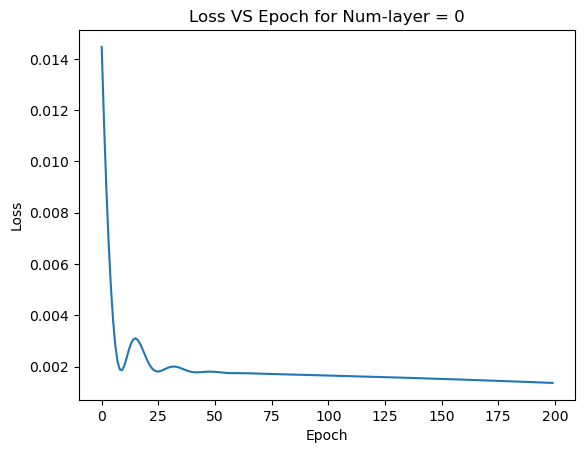

Average MSE Training Loss: 0.0018
Average MAE Training Loss: 0.0342
R2 Training Loss: 0.0002


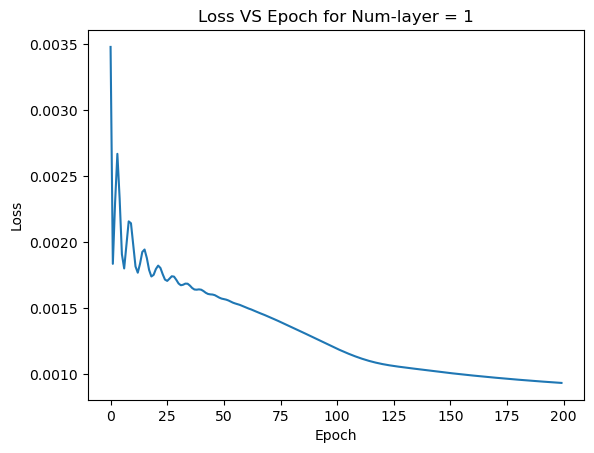

Average MSE Training Loss: 0.0018
Average MAE Training Loss: 0.0343
R2 Training Loss: -0.0134


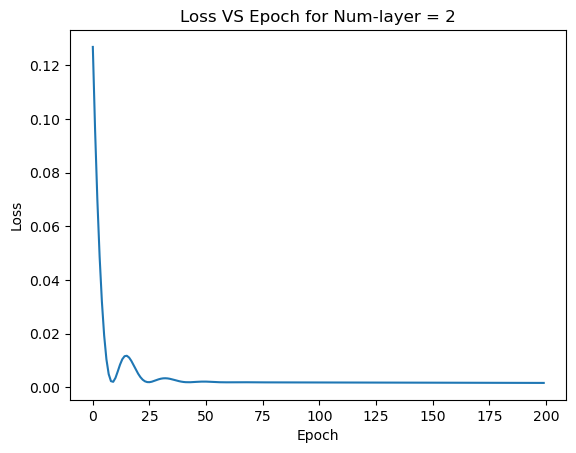

Average MSE Training Loss: 0.0018
Average MAE Training Loss: 0.0344
R2 Training Loss: -0.0098


In [30]:
def r2_score(y_true, y_pred):
    y_mean = torch.mean(y_true)
    total_sum_of_squares = torch.sum((y_true - y_mean) ** 2)
    residual_sum_of_squares = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)
    return r2.item()

input_size = 1
hidden_size = 16
output_size = 1
layer_loss = []
for num_layers in range(3):
    model = ARPredictor(input_size,hidden_size,output_size,num_layers+1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = []
    # Training loop
    num_epochs = 200
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(training_data,1.0)
        loss = criterion(output, training_data[1:])
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
    # Evaluation
    model.eval()
    test_loss_mse = 0.0
    test_loss_mae = 0.0
    test_loss_r2 = 0.0
    criterion_MAE = nn.L1Loss()
    with torch.no_grad():
        output = model(test_data,0.0)
        test_loss_mse = criterion(output, test_data[1:]).item()
        test_loss_mae = criterion_MAE(output, test_data[1:]).item()
        test_loss_r2 = r2_score(test_data[1:].reshape(-1), output.reshape(-1))
    
    plt.plot(range(200),[los for los in losses])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Loss VS Epoch for Num-layer = {num_layers}")
    plt.show()

    print(f'Average MSE Training Loss: {test_loss_mse:.4f}')
    print(f'Average MAE Training Loss: {test_loss_mae:.4f}')
    print(f'R2 Training Loss: {test_loss_r2:.4f}')
    
    layer_loss.append(losses)